## Parameter Fitting to a Simple Series Reaction

jbr book reference: [Figure A.10](https://sites.engineering.ucsb.edu/~jbraw/chemreacfun/fig-html/appendix/fig-A-10.html)

Reaction is $A \xrightarrow[]{k_1} B \xrightarrow[]{k_2} C$

Data simulated for $A$, $B$, and $C$ over time (with added noise) based on:
$ c_{A0} = 1, c_{B0} = 0, c_{c0} = 0, k_1 = 2, k_2 = 1$

The above parameters are also the parameters that will be fitted based on the data

In [16]:
from __future__ import print_function
from kipet.library.TemplateBuilder import *
from kipet.library.PyomoSimulator import *
from kipet.library.ParameterEstimator import *
from kipet.library.VarianceEstimator import *
from kipet.library.data_tools import *
import matplotlib.pyplot as plt
import os
import sys
import inspect
import six
import pandas as pd
from scipy.stats import t

In [3]:
filename = 'ABC_data.csv'
D_frame = read_file(filename, directory = 'data_sets')

read dir : /home/paperspace/learn_kipet/kipet_paresto/data_sets/ABC_data.csv


In [4]:
D_frame.shape

(20, 3)

In [5]:
D_frame.columns = ['A', 'B', 'C']
D_frame

,A,B,C
t,,,
0.000,0.957,-0.031,-0.015
0.263,0.557,0.330,0.044
0.526,0.342,0.512,0.156
0.789,0.224,0.499,0.310
1.053,0.123,0.428,0.454
1.316,0.079,0.396,0.556
1.579,0.035,0.303,0.651
1.842,0.029,0.287,0.658
2.105,0.025,0.221,0.750


In [6]:
builder = TemplateBuilder()    
components = {'A':1,'B':0,'C':0}
builder.add_mixture_component(components)
builder.add_parameter('k1',initialize = 5.0, bounds=(0.0,10.0))
builder.add_parameter('k2',initialize = 5.0, bounds=(0.0,10.0))
builder.add_parameter('ca0', initialize = 1.0, bounds = (0.5, 1.5))
builder.add_parameter('cb0', initialize = 0.0, bounds = (0.0, 1.5))
builder.add_parameter('cc0', initialize = 0.0, bounds = (0.0, 1.5))

builder.add_concentration_data(D_frame)

Warning! Since C-matrix contains negative values Kipet is assuming a derivative of C has been inputted


In [7]:
# define explicit system of ODEs
def rule_odes(m,t):
    exprs = dict()
    exprs['A'] = -m.P['k1']*m.Z[t,'A']
    exprs['B'] = m.P['k1']*m.Z[t,'A']-m.P['k2']*m.Z[t,'B']
    exprs['C'] = m.P['k2']*m.Z[t,'B']
    return exprs

builder.set_odes_rule(rule_odes)
opt_model = builder.create_pyomo_model(0.0,5.0)

In [8]:
# explicitly add constraints for initial conditions and relax the auto-imposed initial conditions by builder
opt_model.ca0_cons = Constraint(expr = opt_model.Z[0, 'A'] == opt_model.P['ca0'])
opt_model.cb0_cons = Constraint(expr = opt_model.Z[0, 'B'] == opt_model.P['cb0'])
opt_model.cc0_cons = Constraint(expr = opt_model.Z[0, 'C'] == opt_model.P['cc0'])
opt_model.init_conditions_c.deactivate()

In [9]:
sigmas = {'A':1, 'B':1, 'C':1}
p_estimator = ParameterEstimator(opt_model)
p_estimator.apply_discretization('dae.collocation',nfe=50,ncp=3,scheme='LAGRANGE-RADAU')

In [10]:
options = dict()
results_pyomo = p_estimator.run_opt('k_aug',
                                    variances=sigmas,
                                  tee=True,
                                  solver_opts = options,
                                  covariance=True)

        0.10 seconds required to write file
        0.10 seconds required for presolve
Ipopt 3.12: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12, running with linear solver ma27.

Number of nonzeros in equality constraint Jacobian...:     3906
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      360

Total number of variables............................:      908
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        5
                     variables with only upper bounds:        0
T

W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in


[K_AUG] written by D.T. @2018

: I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 908
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 903
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 5
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-9.041394934914457 at var_i=300
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-9.041392318707917 at var_i=301
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 903, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 3906
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 360
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.025073
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 848
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC19 scaling...
I[K_AUG

In [11]:
print("The estimated parameters are:")
for k,v in six.iteritems(results_pyomo.P):
    print(k, v)

The estimated parameters are:
k1 2.0135562230845974
k2 0.9855452820531018
ca0 0.9845976673339518
cb0 0.0007208145355505998
cc0 0.010591068714483027


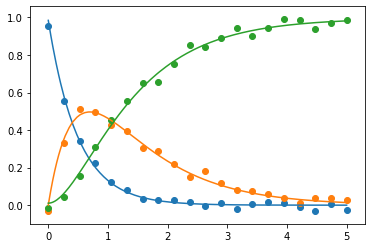

In [12]:
fig, ax = plt.subplots()
for c in ['A', 'B', 'C']:
    ax.scatter(D_frame.index, D_frame[c])
    ax.plot(results_pyomo.Z.index, results_pyomo.Z[c])

In [13]:
results_pyomo.objective

0.025073189805777718

In [14]:
# since kipet outputs reduced hessian which equals covariance if right sigma values are specified. 
# since we just specified sigma=1, we need to adjust the covariance matrix output from KIPET to get the 
# estimated covariance matrix
mse = results_pyomo.objective / (30*3 - 5)
cov_est = 2 * mse * results_pyomo.parameter_covariance
cov_est

array([[ 2.08473427e-03, -1.61587575e-04,  2.03039085e-04,
        -2.63825849e-04,  1.55522778e-06],
       [-1.61587575e-04,  3.26503352e-04,  3.45605377e-05,
         2.25804925e-05, -9.31759044e-05],
       [ 2.03039085e-04,  3.45605377e-05,  1.37994010e-04,
        -1.07673548e-04, -2.63899565e-05],
       [-2.63825849e-04,  2.25804925e-05, -1.07673548e-04,
         1.68735055e-04, -4.98853058e-05],
       [ 1.55522778e-06, -9.31759044e-05, -2.63899565e-05,
        -4.98853058e-05,  8.87387080e-05]])

In [19]:
dof = 20*3 - 5
conf_delta = t.ppf(0.975, dof) * np.sqrt(np.diag(cov_est))
conf_delta

array([0.09150246, 0.03621189, 0.02354168, 0.02603215, 0.01887835])

In [23]:
# confidence limits of parameters
i = 0
for k, v in six.iteritems(results_pyomo.P):
    print(f"{k}, {v - conf_delta[i]:.2f}, {v + conf_delta[i]:.2f}")
    i = i + 1

k1, 1.92, 2.11
k2, 0.95, 1.02
ca0, 0.96, 1.01
cb0, -0.03, 0.03
cc0, -0.01, 0.03
